### Specific Test III. Image Super-resolution


#### **Name**:potla naga sai bharath 
#### **Gmail**:[saibharathpotla29@gmail.com](mailto:saibharathpotla29@gmail.com)

**Task:** Train a deep learning-based super-resolution algorithm of your choice to enhance low-resolution strong lensing images using a limited dataset of real HR/LR pairs collected from HSC and HST telescopes. You can adapt and fine-tune your super-resolution model from Task III.A. or use any other approach, such as few-shot learning strategies, transfer learning, domain adaptation, or data augmentation techniques, etc. Please implement your approach in PyTorch or Keras and discuss your strategy

**Dataset Description:** The dataset comprises 300 strong lensing image pairs at multiple resolutions: high-resolution (HR) and low-resolution (LR)

**Evaluation Metrics:** MSE (Mean Squared Error), SSIM (Structural Similarity Index), PSNR (Peak Signal-to-Noise Ratio)

*Trained model weigths for this task can be found in the respective folder in [HERE](https://drive.google.com/drive/folders/1DGug4hP0UZBG2zAVWiO5lAgrlnf95l_Q?usp=drive_link)*


**Strategy**:
### SuperResCNN (Super-Resolution Convolutional Neural Network)
- In Task 3a, compared to all the resolution models above, SuperResCNN performed better. Therefore, we will use the same model for the task.

### FSRCNN(Fast Super-Resolution Convolutional Neural Network)
- The SuperResCNN model is not effective for the given task. Instead, we will use the FERCNN mode


- FSRCNN has a relatively shallow network, which allows us to understand the effect of each component more easily. It is even faster and produces better reconstructed image quality compared to the previous SRCNN model.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

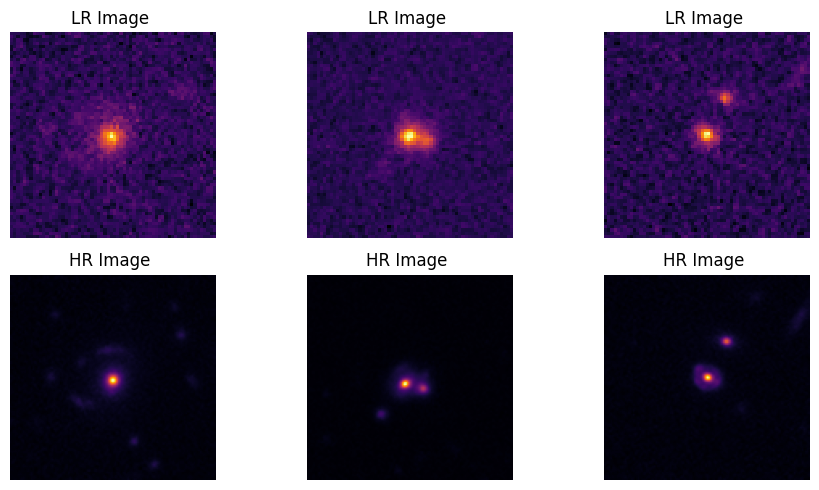

In [6]:
# Path to the main folder containing subfolders
main_folder = '/kaggle/working/Dataset'

# Subfolders for LR and HR images
lr_folder = os.path.join(main_folder, 'LR')
hr_folder = os.path.join(main_folder, 'HR')

# Load and plot first five LR images
plt.figure(figsize=(15, 5))
for i in range(1, 4):
    lr_image_path = os.path.join(lr_folder, f'LR_{i}.npy')
    lr_image = np.load(lr_image_path)
    plt.subplot(2, 5, i)
    plt.imshow(lr_image.T,'inferno')
    plt.title(f'LR Image ')
    plt.axis('off')

# Load and plot first five HR images
for i in range(1, 4):
    hr_image_path = os.path.join(hr_folder, f'HR_{i}.npy')
    hr_image = np.load(hr_image_path)
    plt.subplot(2, 5, i + 5)
    plt.imshow(hr_image.T,'inferno')
    plt.title(f'HR Image ')
    plt.axis('off')

plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


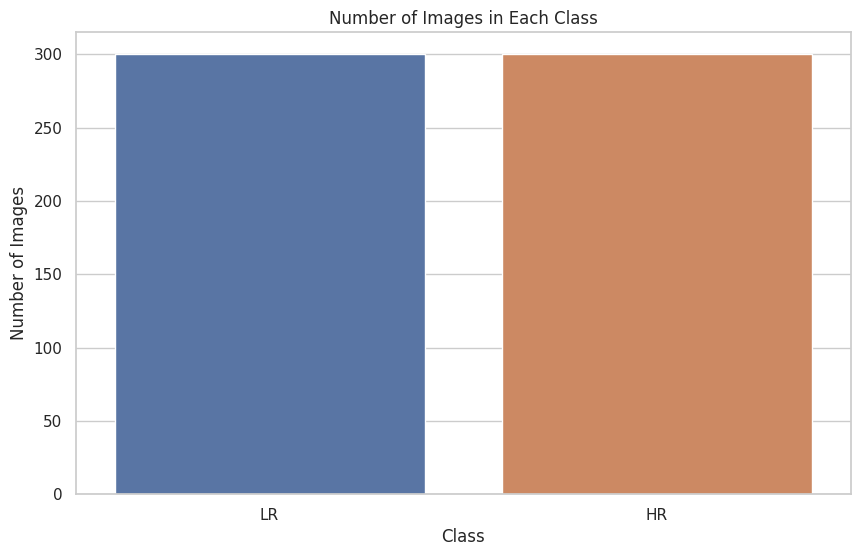

In [7]:
def count_images_per_class(data_dir):
    classes = os.listdir(data_dir)
    class_counts = []

    for cls in classes:
        cls_path = os.path.join(data_dir, cls)
        if os.path.isdir(cls_path):
            images = [f for f in os.listdir(cls_path) if f.endswith('.npy')]
            num_images = len(images)
            class_counts.append((cls, num_images))

    return class_counts

# Get the total number of images in each class
class_counts = count_images_per_class(main_folder)

# Plot the countplot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(x=[cls[0] for cls in class_counts], y=[cls[1] for cls in class_counts])
plt.title('Number of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

In [3]:
import glob 
from sklearn.model_selection import train_test_split
hr_images = np.array([np.load(file_path) for file_path in glob.glob('Dataset/HR/*.npy')])
lr_images = np.array([np.load(file_path) for file_path in glob.glob('Dataset/LR/*.npy')])

# Split into training and validation sets
train_hr, val_hr, train_lr, val_lr = train_test_split(hr_images, lr_images, test_size=0.1, random_state=42) # (None, 1, x, x)

# Preprocess the data

print(train_hr.shape, val_hr.shape, train_lr.shape, val_lr.shape)

(270, 1, 128, 128) (30, 1, 128, 128) (270, 1, 64, 64) (30, 1, 64, 64)


In [4]:
# Reshape the data to the format (batch, height, width, channel)
train_hr, val_hr =  np.reshape(train_hr, (270,128, 128,1)),np.reshape(val_hr, (30,128, 128,1))
train_lr, val_lr = np.reshape(train_lr, (270,64, 64,1)),np.reshape(val_lr, (30,64, 64,1))

In [5]:
def evaluate_models(model, val_lr, val_hr):
    """
    About: 
        Evaluates a given image super-resolution model on a validation set of low-resolution and high-resolution images, using mean squared error (MSE), structural similarity index (SSIM), and peak signal-to-noise ratio (PSNR) as evaluation metrics.
        
    """
    mse_values = []
    ssim_values = []
    psnr_values = []

    for i in range(len(val_lr)):
        # Predict the high-resolution image using the model
        pred_hr = model.predict(np.expand_dims(val_lr[i], axis=0), verbose = 0)[0]

        # Calculate the mean squared error
        mse = mean_squared_error(val_hr[i], pred_hr)
        mse_values.append(mse)

        # Calculate the structural similarity index
        ssim_val = ssim(val_hr[i], pred_hr, channel_axis=-1,gaussian_weights=True,sigma=1.5,use_sample_covariance=False, data_range=255)
        ssim_values.append(ssim_val)

        # Calculate the peak signal-to-noise ratio
        psnr_val = psnr(val_hr[i], pred_hr, data_range=pred_hr.max() - pred_hr.min())
        psnr_values.append(psnr_val)

    # Calculate the mean of the metrics
    mean_mse = np.mean(mse_values)
    mean_ssim = np.mean(ssim_values)
    mean_psnr = np.mean(psnr_values)
    return mean_mse, mean_ssim, mean_psnr

In [6]:
def view_predictions(model, index, title):
    """
    About: 
      Display the low-resolution image, ground truth high-resolution image, and the predicted high-resolution image using a given model for a specified image index.
    """
    predicted_hr = model.predict(np.expand_dims(val_lr[index], axis=0))
    
    fig, ax = plt.subplots(1,3, figsize=(12, 8), dpi=140)
    ax[0].imshow(val_lr[index].squeeze(), cmap='inferno')
    ax[0].set_aspect('equal')
    ax[0].set_title('Low Resolution Image', fontsize=12)

    ax[1].imshow(val_hr[index].squeeze(),cmap='inferno')
    ax[1].set_aspect('equal')
    ax[1].set_title('Ground Truth High Resolution Image', fontsize=12)

    ax[2].imshow(predicted_hr.squeeze(),cmap='inferno')
    ax[2].set_aspect('equal')
    ax[2].set_title('Predicted Image', fontsize=12)

    plt.show()

### SuperResCNN (Super-Resolution Convolutional Neural Network)

In [12]:
import keras
import keras.backend as K
from keras.optimizers import Adam
from keras.applications import VGG19
from keras.losses import MeanSquaredError
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Conv2D, UpSampling2D, Conv2DTranspose, Input, ReLU, Add, Lambda, Activation, LeakyReLU, BatchNormalization, Dense, Flatten, GlobalAveragePooling2D, Concatenate, Layer
from skimage.metrics import mean_squared_error, structural_similarity as ssim, peak_signal_noise_ratio as psnr
def create_srcnn_model():

    model = Sequential([
        UpSampling2D(size=(2, 2), input_shape=(64, 64, 1)),
        Conv2D(1024, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (1, 1), activation='relu', padding='same'),
        Conv2D(1, (3, 3), activation='linear', padding='same')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),loss='mean_squared_error', metrics=['mae'])
    return model

srcnn = create_srcnn_model()


srcnn.fit(train_lr, train_hr, validation_data=(val_lr, val_hr), epochs=50, batch_size=6)

2024-04-01 13:52:08.858343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 13:52:08.858443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 13:52:09.028951: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/50


I0000 00:00:1711979545.783551      94 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 [==============================] - 14s 120ms/step - loss: 0.0030 - mae: 0.0298 - val_loss: 0.0022 - val_mae: 0.0264
Epoch 2/50
45/45 [==============================] - 5s 115ms/step - loss: 0.0027 - mae: 0.0271 - val_loss: 0.0020 - val_mae: 0.0259
Epoch 3/50
45/45 [==============================] - 5s 114ms/step - loss: 0.0026 - mae: 0.0271 - val_loss: 0.0019 - val_mae: 0.0238
Epoch 4/50
45/45 [==============================] - 5s 114ms/step - loss: 0.0027 - mae: 0.0262 - val_loss: 0.0024 - val_mae: 0.0295
Epoch 5/50
45/45 [==============================] - 5s 116ms/step - loss: 0.0029 - mae: 0.0281 - val_loss: 0.0022 - val_mae: 0.0280
Epoch 6/50
45/45 [==============================] - 5s 116ms/step - loss: 0.0027 - mae: 0.0276 - val_loss: 0.0022 - val_mae: 0.0217
Epoch 7/50
45/45 [==============================] - 5s 117ms/step - loss: 0.0028 - mae: 0.0275 - val_loss: 0.0019 - val_mae: 0.0240
Epoch 8/50
45/45 [==============================] - 5s 118ms/step - loss: 0.0026 - mae

In [13]:
srcnn.save('srcnn.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
from keras.models import Sequential, Model, load_model
srcnn = load_model('srcnn.h5',compile=False)

In [15]:
mean_mse, mean_ssim, mean_psnr = evaluate_models(srcnn, val_lr, val_hr)
print("Mean Squared Error: ", mean_mse)
print("Structural Similarity Index: ", mean_ssim,)
print("Peak Signal-to-Noise Ratio: ",mean_psnr)

Mean Squared Error:  0.001934072869205798
Structural Similarity Index:  0.99973094
Peak Signal-to-Noise Ratio:  18.907184229295


1/1 [==============================] - 53s 53s/step


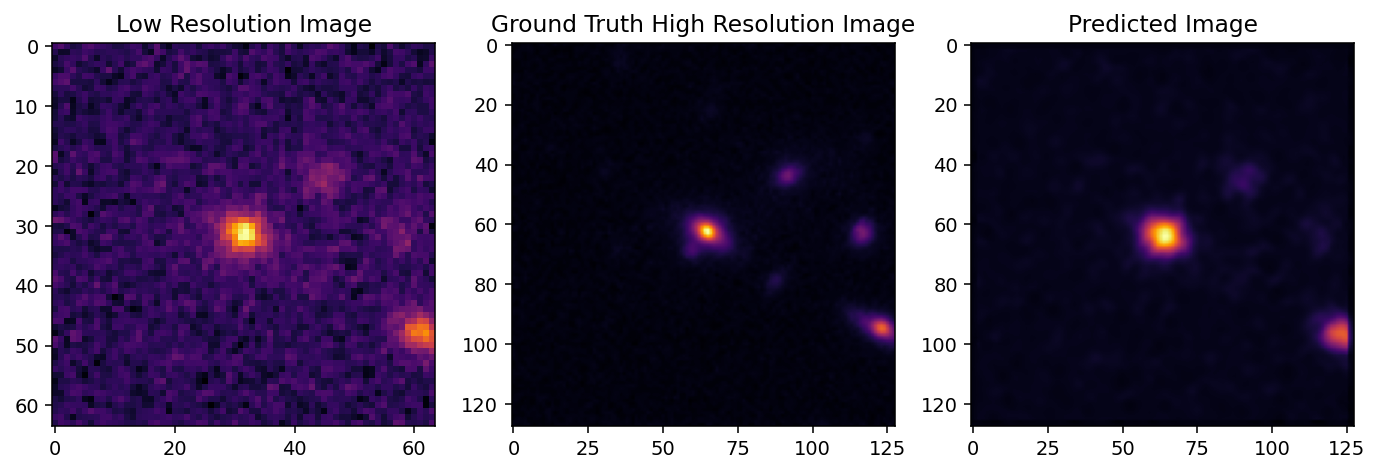

1/1 [==============================] - 0s 206ms/step


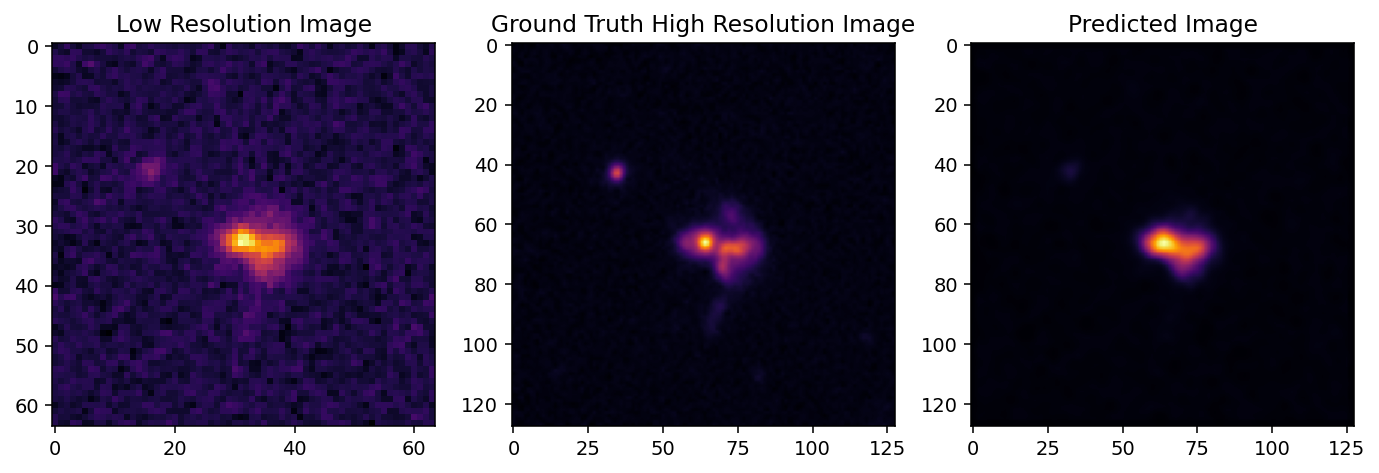

1/1 [==============================] - 0s 25ms/step


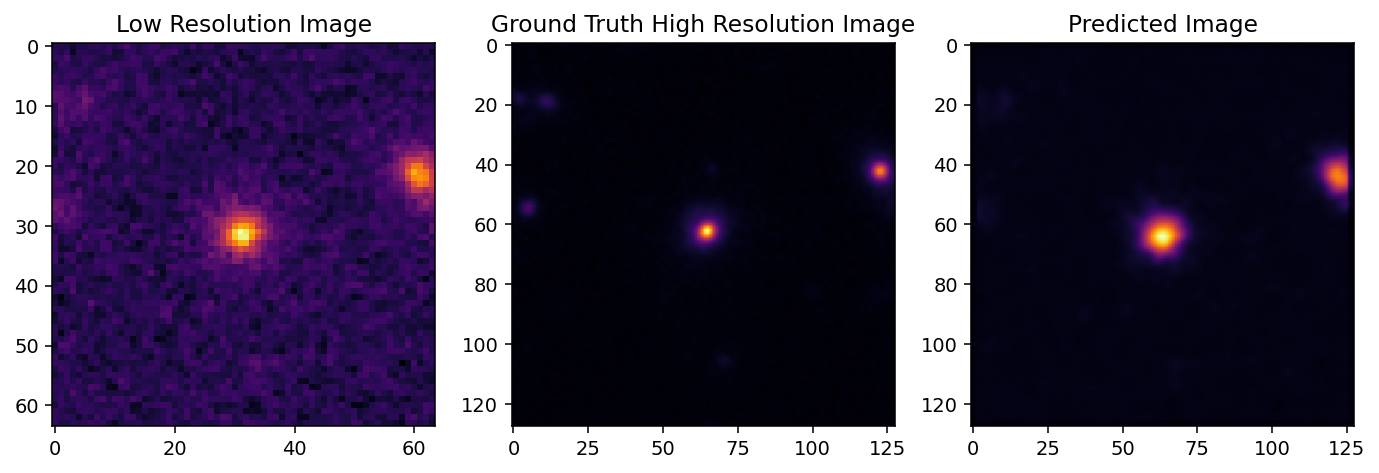

1/1 [==============================] - 0s 25ms/step


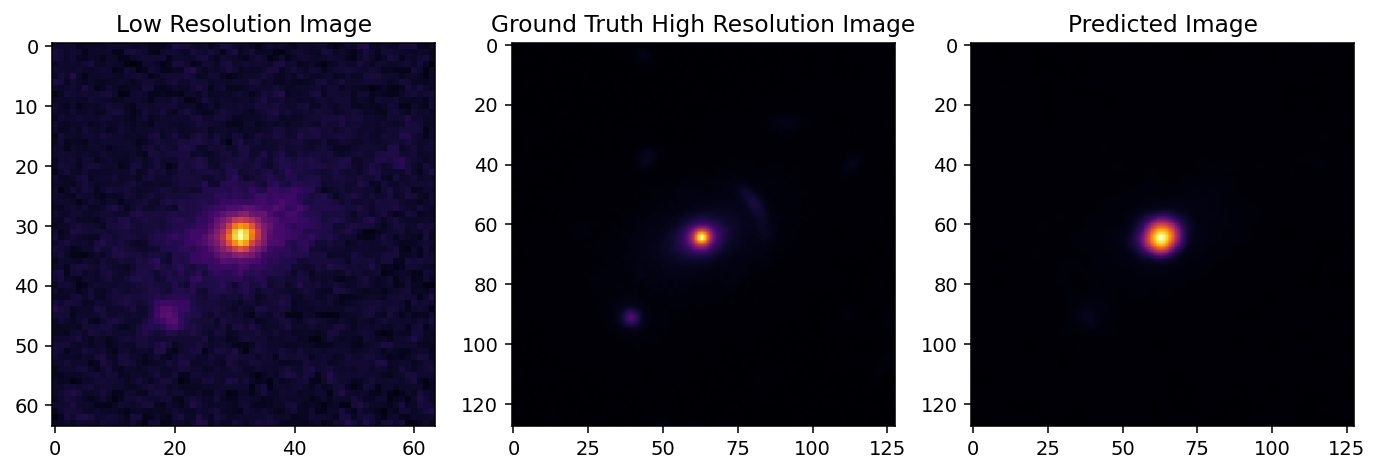

1/1 [==============================] - 0s 25ms/step


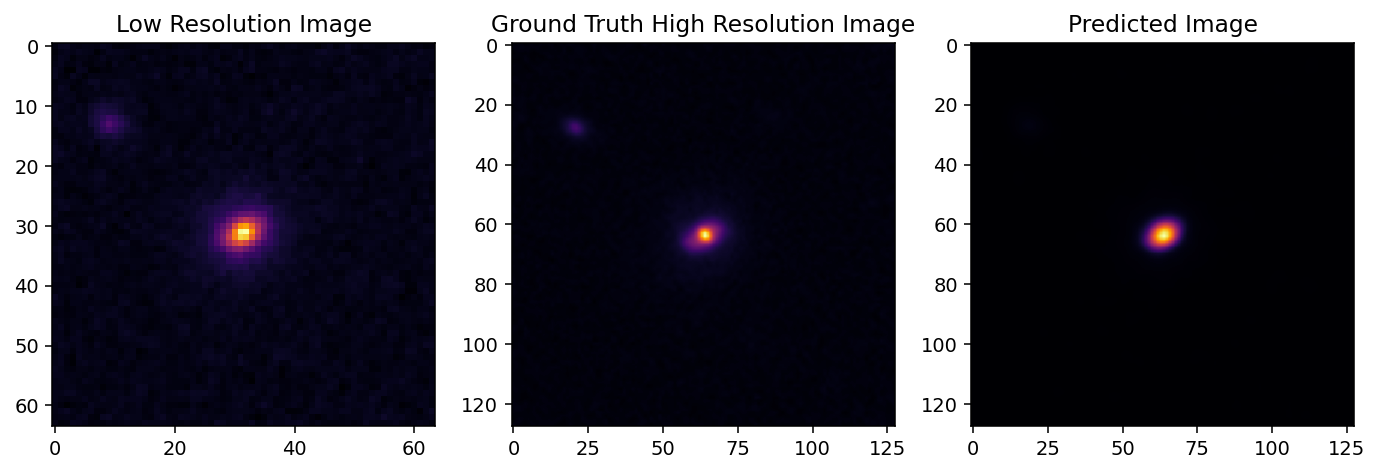

In [10]:
for i in range(5):
    view_predictions(srcnn, i, f'Image {i+1}')

### FSRCNN(Fast Super-Resolution Convolutional Neural Network)

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_first_part(inputs, d):
    x = layers.Conv2D(d, kernel_size=5, padding='same')(inputs)
    x = layers.PReLU(shared_axes=[1, 2])(x)
    return x

def build_mid_part(inputs, s, m):
    x = inputs
    for _ in range(m):
        x = layers.Conv2D(s, kernel_size=3, padding='same')(x)
        x = layers.PReLU(shared_axes=[1, 2])(x)
    return x

def build_last_part(inputs, scale_factor, num_channels):
    x = layers.Conv2DTranspose(num_channels, kernel_size=9, strides=scale_factor, padding='same')(inputs)
    return x

def FSRCNN(scale_factor=2, num_channels=1, d=64, s=12, m=4):
    inputs = tf.keras.Input(shape=(None, None, num_channels))
    x1 = build_first_part(inputs, d)
    x2 = build_mid_part(x1, s, m)
    outputs = build_last_part(x2, scale_factor, num_channels)
    return tf.keras.Model(inputs, outputs)

# Example usage:
model = FSRCNN()



In [18]:
frcnn=FSRCNN()
frcnn.compile(optimizer=Adam(learning_rate=2e-4),loss='mean_squared_error', metrics=['mae'])
frcnn.fit(train_lr, train_hr, validation_data=(val_lr, val_hr), epochs=50, batch_size=16)

Epoch 1/50
17/17 [==============================] - 5s 67ms/step - loss: 0.0039 - mae: 0.0303 - val_loss: 0.0028 - val_mae: 0.0257
Epoch 2/50
17/17 [==============================] - 0s 14ms/step - loss: 0.0031 - mae: 0.0289 - val_loss: 0.0024 - val_mae: 0.0251
Epoch 3/50
17/17 [==============================] - 0s 14ms/step - loss: 0.0029 - mae: 0.0269 - val_loss: 0.0024 - val_mae: 0.0282
Epoch 4/50
17/17 [==============================] - 0s 14ms/step - loss: 0.0028 - mae: 0.0281 - val_loss: 0.0023 - val_mae: 0.0260
Epoch 5/50
17/17 [==============================] - 0s 14ms/step - loss: 0.0028 - mae: 0.0269 - val_loss: 0.0023 - val_mae: 0.0259
Epoch 6/50
17/17 [==============================] - 0s 14ms/step - loss: 0.0027 - mae: 0.0276 - val_loss: 0.0022 - val_mae: 0.0260
Epoch 7/50
17/17 [==============================] - 0s 14ms/step - loss: 0.0027 - mae: 0.0270 - val_loss: 0.0022 - val_mae: 0.0251
Epoch 8/50
17/17 [==============================] - 0s 14ms/step - loss: 0.0026 - m

In [ ]:
frcnn.save('/kaggle/working/frcnn')
frcnn = load_model('/kaggle/working/frcnn')

In [20]:
mean_mse, mean_ssim, mean_psnr = evaluate_models(frcnn, val_lr, val_hr)
print("Mean Squared Error: ", mean_mse)
print("Structural Similarity Index: ", mean_ssim,)
print("Peak Signal-to-Noise Ratio: ",mean_psnr)

Mean Squared Error:  0.0017680485316219862
Structural Similarity Index:  0.99975455
Peak Signal-to-Noise Ratio:  23.614782785662133


1/1 [==============================] - 3s 3s/step


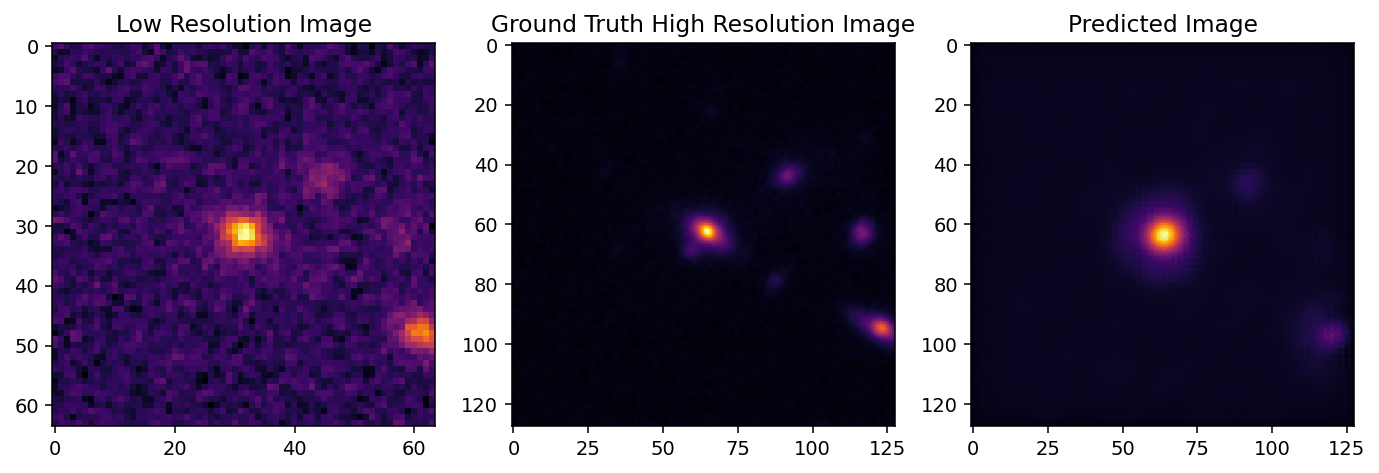

1/1 [==============================] - 0s 49ms/step


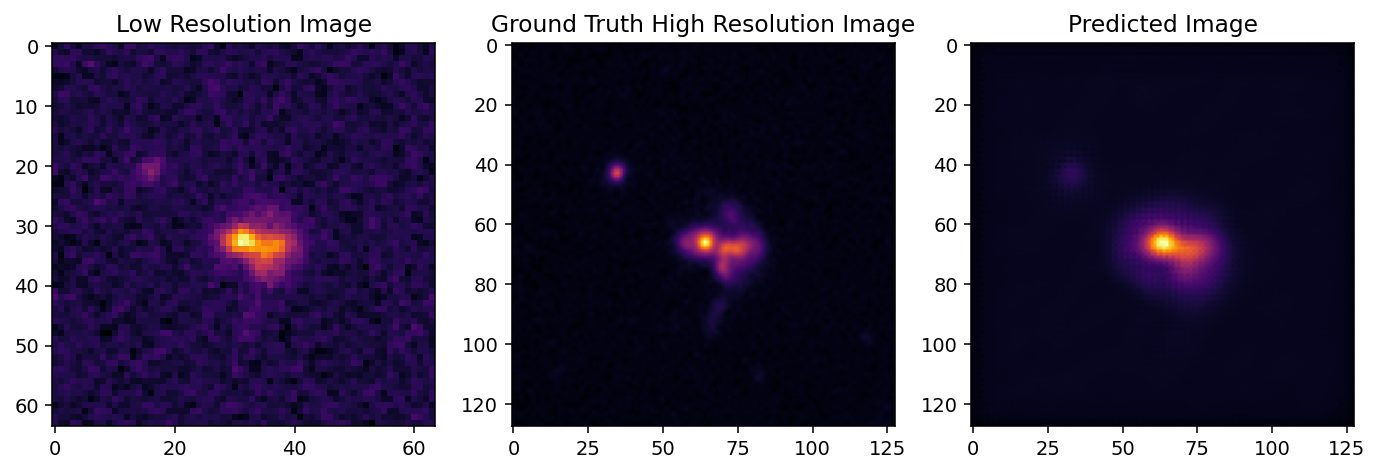

1/1 [==============================] - 0s 33ms/step


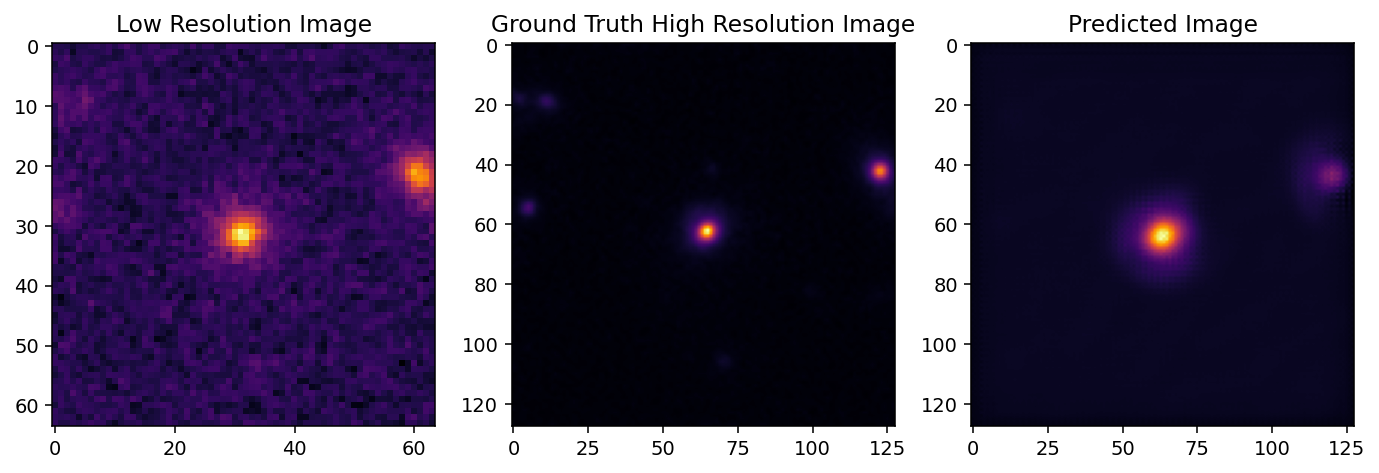

1/1 [==============================] - 0s 33ms/step


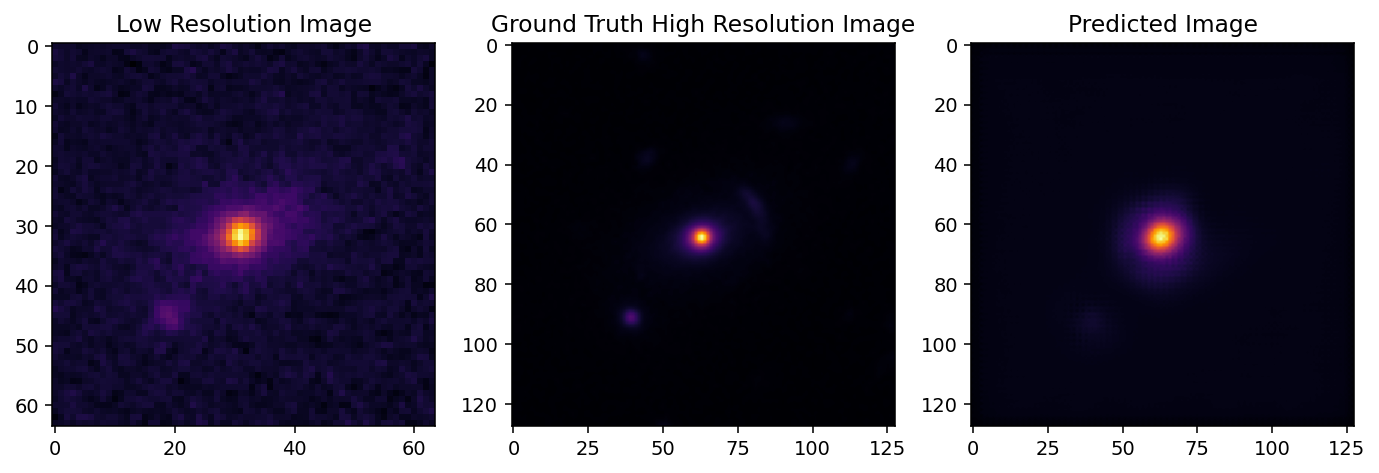

1/1 [==============================] - 0s 25ms/step


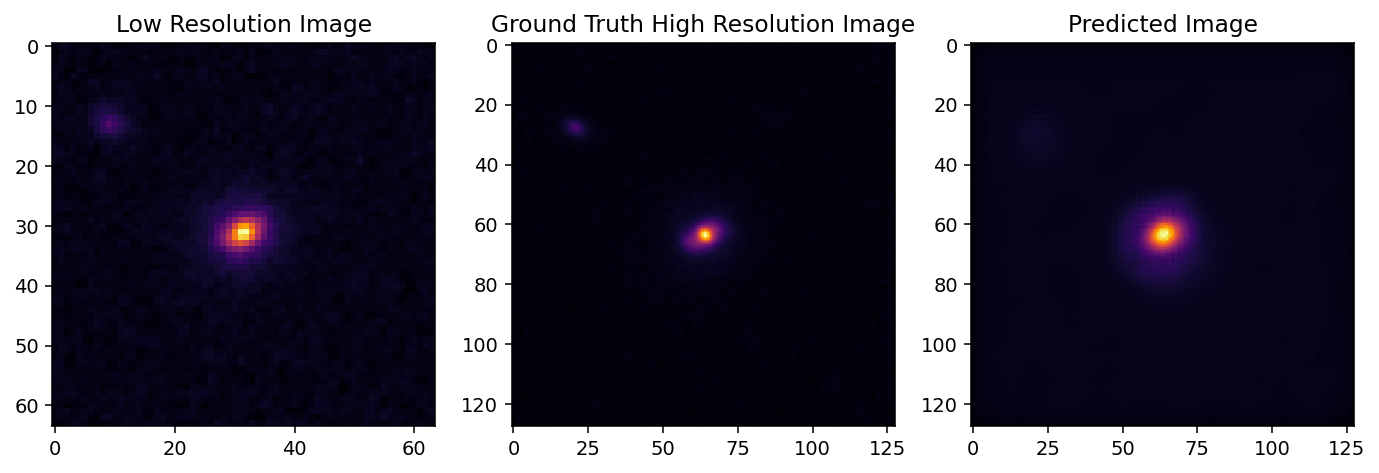

In [12]:
for i in range(5):
    view_predictions(frcnn, i, f'Image {i+1}')